In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2)),
    transforms.Normalize((.0,), (1.0,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


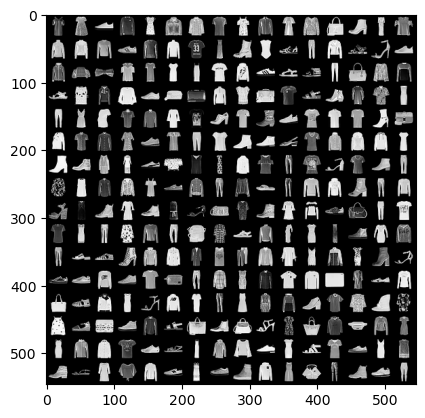

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 2)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


In [5]:
from torchsummary import summary

encoder = Encoder().to('cuda')


In [6]:
summary(encoder, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
            Conv2d-2             [-1, 64, 8, 8]          18,496
            Conv2d-3            [-1, 128, 4, 4]          73,856
            Linear-4                    [-1, 2]           4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.37
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()        
        self.fc = nn.Linear(2, 2048)
        
        self.conv_transpose1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        
        self.conv_transpose2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        
        self.conv_transpose3 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )
        
        self.conv_output = nn.Conv2d(
            in_channels=32,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        x = self.conv_transpose3(x)
        x = self.conv_output(x)
        x = torch.sigmoid(x)
        return x

In [8]:
decoder = Decoder().to('cuda')

In [9]:
summary(decoder, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
   ConvTranspose2d-3           [-1, 64, 16, 16]          73,792
   ConvTranspose2d-4           [-1, 32, 32, 32]          18,464
            Conv2d-5            [-1, 1, 32, 32]             289
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.94
Estimated Total Size (MB): 1.40
----------------------------------------------------------------


In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [11]:
autoencoder = Autoencoder().to('cuda')
summary(autoencoder, (1, 32, 32))
criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
            Conv2d-2             [-1, 64, 8, 8]          18,496
            Conv2d-3            [-1, 128, 4, 4]          73,856
            Linear-4                    [-1, 2]           4,098
           Encoder-5                    [-1, 2]               0
            Linear-6                 [-1, 2048]           6,144
   ConvTranspose2d-7            [-1, 128, 8, 8]         147,584
   ConvTranspose2d-8           [-1, 64, 16, 16]          73,792
   ConvTranspose2d-9           [-1, 32, 32, 32]          18,464
           Conv2d-10            [-1, 1, 32, 32]             289
          Decoder-11            [-1, 1, 32, 32]               0
Total params: 343,043
Trainable params: 343,043
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [12]:
num_epochs = 3

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to('cuda'), labels.to('cuda')    
        output = autoencoder(imgs)
        loss = criterion(output, imgs)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/3], Loss: 0.3383
Epoch [2/3], Loss: 0.3264
Epoch [3/3], Loss: 0.2929


In [13]:
from safetensors.torch import save_model, load_model


In [14]:
save_model(autoencoder, "data/autoencoder.safetensors")


In [15]:
ae = Autoencoder()

In [16]:
load_model(ae, "data/autoencoder.safetensors")

(set(), [])

In [17]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

test_x, test_label = next(iter(test_loader))

In [18]:
test_y = ae(test_x)

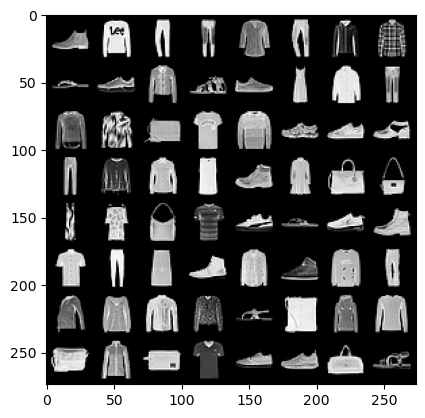

In [19]:
imshow(torchvision.utils.make_grid(test_x[:64]))

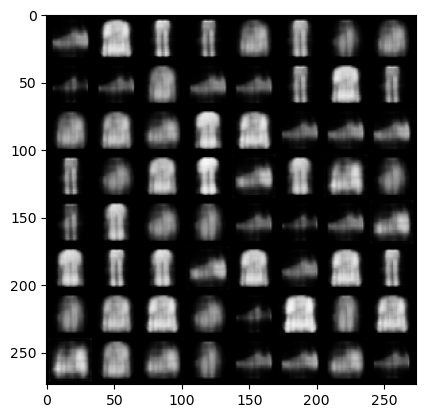

In [20]:
imshow(torchvision.utils.make_grid(test_y[:64]))

In [21]:
with torch.no_grad():
    embeddings = ae.encoder(test_x)

In [22]:
print(embeddings[:10])

tensor([[ -3.9217,  -2.1772],
        [ -2.3488,  -6.7753],
        [-11.7427, -15.7399],
        [-11.5288, -14.2796],
        [ -3.1339,  -5.2869],
        [ -9.5692, -13.1721],
        [ -6.4742,  -7.9140],
        [ -3.7675,  -5.6043],
        [ -9.2208,  -5.7525],
        [ -6.2197,  -3.5025]])


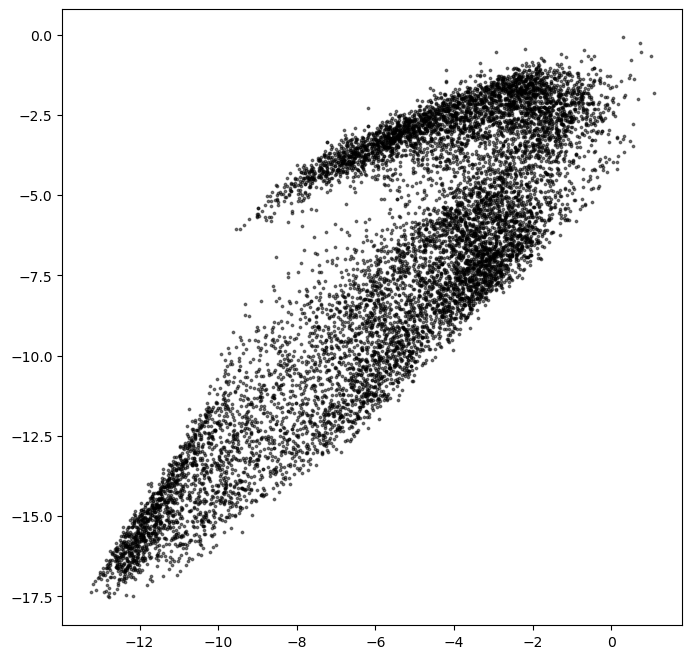

In [23]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

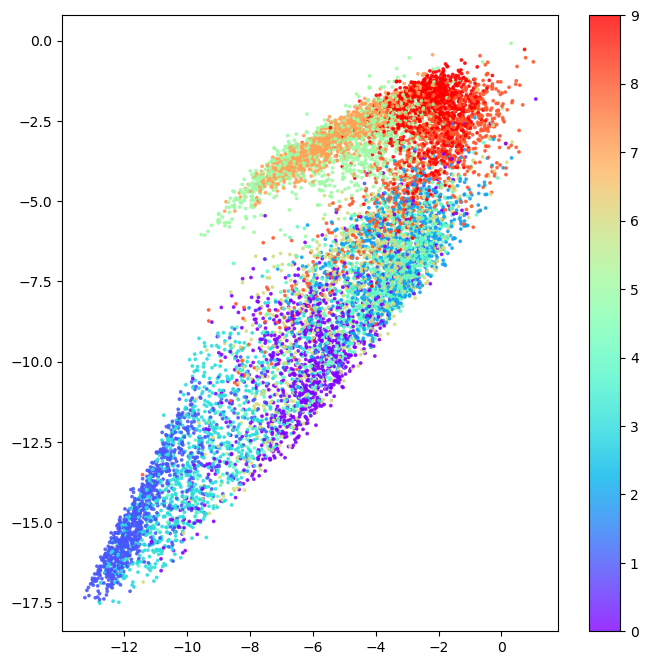

In [24]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [25]:
mins, _ = torch.min(embeddings, dim=0)
maxs, _ = torch.max(embeddings, dim=0)
mins, maxs

(tensor([-13.2505, -17.5260]), tensor([ 1.0939, -0.0808]))

In [26]:
grid_width, grid_height = (8, 8)
sample = (maxs - mins) * torch.rand(64, 2) + mins
sample

tensor([[ -3.2606,  -8.2397],
        [ -3.6271, -11.6084],
        [ -5.2521, -17.4594],
        [ -0.5262,  -3.9373],
        [-12.2160, -17.4719],
        [ -4.6541,  -1.1210],
        [ -1.3181, -13.2937],
        [ -4.4533,  -4.1748],
        [ -7.8433, -14.7256],
        [-12.0514,  -6.7795],
        [ -3.6157, -10.3344],
        [ -4.7406, -13.6384],
        [-12.9057,  -3.6218],
        [-10.6716, -16.6575],
        [ -2.1229, -11.0404],
        [ -4.9355, -16.0254],
        [ -1.2169, -10.0905],
        [ -7.7425, -13.3197],
        [ -7.2558,  -0.2710],
        [ -8.6901,  -4.6823],
        [ -2.3954, -15.1697],
        [-11.1619, -10.0663],
        [ -3.8223, -16.0444],
        [-12.5769,  -7.6608],
        [ -0.6178, -17.1358],
        [ -6.9410,  -6.7767],
        [ -5.2856,  -9.3846],
        [  0.1598,  -2.7755],
        [ -3.2346,  -6.2988],
        [ -9.9628,  -7.5411],
        [ -3.0239,  -6.2488],
        [ -7.3824, -12.9709],
        [ -0.6338,  -6.1902],
        [ 

In [27]:
with torch.no_grad():
    reconstructions = ae.decoder(sample)
reconstructions[0].shape

torch.Size([1, 32, 32])

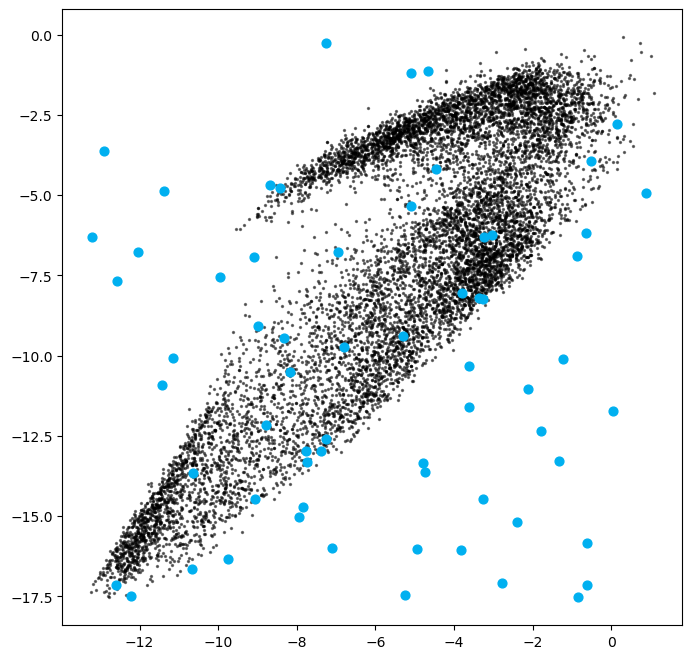

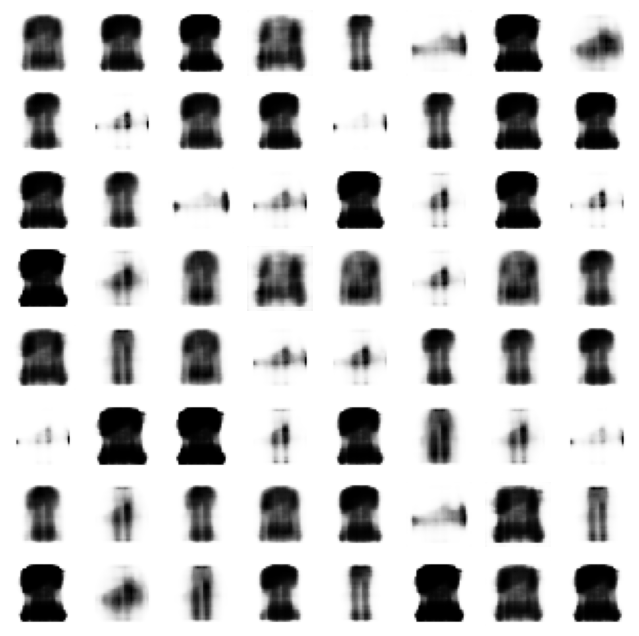

In [28]:

plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")

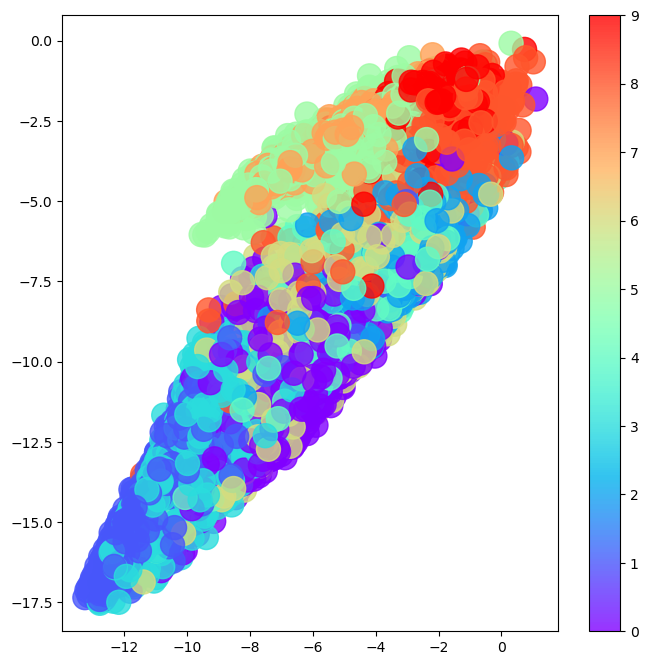

In [29]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=300,
)
plt.colorbar()
plt.show()

In [30]:
grid_size = 16

x = torch.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = torch.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = torch.meshgrid(x, y, indexing='ij')
xv = xv.flatten()
yv = yv.flatten()
grid = torch.stack((xv, yv), dim=1)
grid.shape

torch.Size([256, 2])

In [31]:
with torch.no_grad():
    reconstructions = ae.decoder(grid)

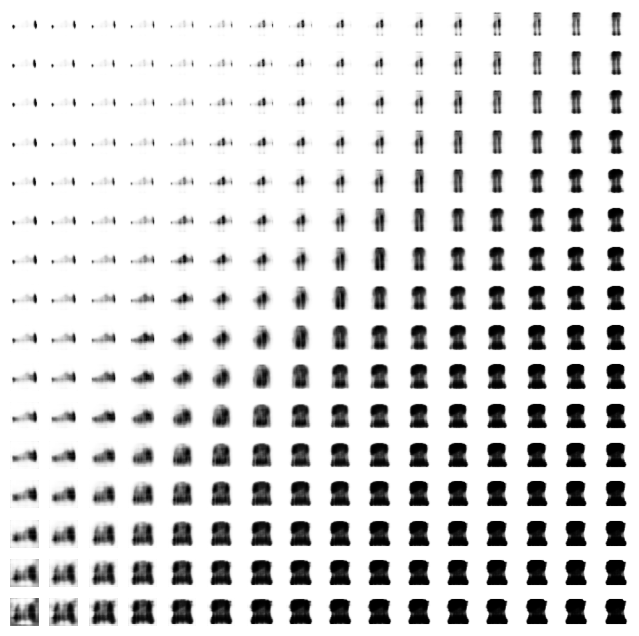

In [32]:
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")